<a href="https://colab.research.google.com/github/chrisluedtke/chi-array-of-things/blob/master/Intro-to-Chicago-Array-of-Things.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An Exploration of Chicago's Array of Things API (via python client)
[Array of Things](https://arrayofthings.github.io/index.html) has expanded in Chicago to include more than 100 continuous sensors across the city.

There is a handy [python client](https://github.com/UrbanCCD-UChicago/aot-client-py).

And of course the [API documentation](https://arrayofthings.docs.apiary.io).

In [67]:
!pip install aot-client

In [121]:
from aot_client import AotClient

client = AotClient()

# What are the methods/properties or the client?
[_ for _ in dir(client) if '__' not in _]

['_hostname',
 '_send_request',
 'get_node_details',
 'get_project_details',
 'get_sensor_details',
 'list_nodes',
 'list_observations',
 'list_projects',
 'list_raw_observations',
 'list_sensors']

In [117]:
help(client.list_observations)

Help on method list_observations in module aot_client.client:

list_observations(filters:aot_client.filters.F=None) -> aot_client.responses.PagedResponse method of aot_client.client.AotClient instance
    Returns a ``PagedResponse`` object with a list of *observations*.
    Observations are the data collected by the sensors.
    
    See the `API documentation`_ for details on the system design.
    
    .. _API documentation: https://api.arrayofthings.org/docs
    
    :param filters: Query parameters applied to the request



It appears results will be paginated and we can also pass a filter. From the docs website I see that users may pass a timestamp filter in ISO 8601 format. Let's get measurements from the past 15 minutes.

In [167]:
import datetime

import pandas as pd
from aot_client import F


hr_diff = 0.25
t = datetime.datetime.now() - datetime.timedelta(hours=hr_diff)
t = t.isoformat()
print(f"observations since:{t}")

observations = client.list_observations(
    filters=F('timestamp', f'ge:{t}')
)

# Note this could take a while, even for just 15 mins of data
pages = []
for page in observations:
    pages += page.data
    
obs_df = pd.DataFrame(pages)
print(f"shape: {obs_df.shape}")
obs_df.head()

2019-01-08T22:11:00.341089
(20723, 4)


,node_vsn,sensor_path,timestamp,value
0,085,metsense.tsys01.temperature,2019-01-08T22:20:45,6.240
1,085,metsense.tsl250rd.intensity,2019-01-08T22:20:45,3.827
2,085,metsense.tmp112.temperature,2019-01-08T22:20:45,6.560
3,085,metsense.spv1840lr5h_b.intensity,2019-01-08T22:20:45,56.720
4,085,metsense.pr103j2.temperature,2019-01-08T22:20:45,6.650


Where in the city are measurements being taken? Let's look at our nodes.

In [232]:
nodes = client.list_nodes()

nodes_df = pd.DataFrame(nodes.data)
nodes_df.head()

,address,commissioned_on,decommissioned_on,description,location,vsn
0,State St & Jackson Blvd Chicago IL,2017-10-09T00:00:00,None,AoT Chicago (S) [C],"{'type': 'Point', 'crs': {'type': 'name', 'pro...",004
1,18th St & Lake Shore Dr Chicago IL,2017-08-08T00:00:00,None,AoT Chicago (S),"{'type': 'Point', 'crs': {'type': 'name', 'pro...",006
2,Cornell & 47th St Chicago IL,2017-08-08T00:00:00,None,AoT Chicago (S),"{'type': 'Point', 'crs': {'type': 'name', 'pro...",00D
3,Ohio St & Grand Ave Chicago IL,2017-12-01T00:00:00,2018-06-04T00:00:00,AoT Chicago (S) [C],"{'type': 'Point', 'crs': {'type': 'name', 'pro...",010
4,Stony Island Ave & 63rd St Chicago IL,2018-02-26T00:00:00,None,AoT Chicago (S) [C],"{'type': 'Point', 'crs': {'type': 'name', 'pro...",018


In [233]:
nodes_df['location'][0]

{'coordinates': [-87.627678, 41.878377],
 'crs': {'properties': {'name': 'EPSG:4326'}, 'type': 'name'},
 'type': 'Point'}

In [234]:
nodes_df['coords'] = nodes_df['location'].apply(lambda x: x['coordinates'])
nodes_df[['lon', 'lat']] = pd.DataFrame(nodes_df['coords'].tolist(), columns=['lon', 'lat'])
nodes_df = nodes_df.drop(['location', 'coords'], axis=1)
nodes_df.head()

,address,commissioned_on,decommissioned_on,description,vsn,lon,lat
0,State St & Jackson Blvd Chicago IL,2017-10-09T00:00:00,None,AoT Chicago (S) [C],004,-87.627678,41.878377
1,18th St & Lake Shore Dr Chicago IL,2017-08-08T00:00:00,None,AoT Chicago (S),006,-87.616055,41.858136
2,Cornell & 47th St Chicago IL,2017-08-08T00:00:00,None,AoT Chicago (S),00D,-87.590228,41.810342
3,Ohio St & Grand Ave Chicago IL,2017-12-01T00:00:00,2018-06-04T00:00:00,AoT Chicago (S) [C],010,-87.611603,41.891964
4,Stony Island Ave & 63rd St Chicago IL,2018-02-26T00:00:00,None,AoT Chicago (S) [C],018,-87.586456,41.780600


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


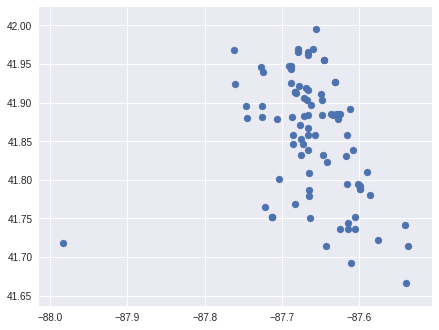

In [229]:
import matplotlib.pyplot as plt

plt.scatter(nodes_df['lon'], nodes_df['lat'])
plt.axes().set_aspect('equal')
plt.show()

Yup, that looks like Chicago!

Let's merge these coordinates into our observations and visualize some sensor data.

In [183]:
df = obs_df.merge(nodes_df[['vsn', 'lon', 'lat']], left_on='node_vsn', right_on='vsn')
df = df.drop('vsn', axis=1)
df.head()

,node_vsn,sensor_path,timestamp,value,lon,lat
0,085,metsense.tsys01.temperature,2019-01-08T22:20:45,6.240,-87.663518,41.75034
1,085,metsense.tsl250rd.intensity,2019-01-08T22:20:45,3.827,-87.663518,41.75034
2,085,metsense.tmp112.temperature,2019-01-08T22:20:45,6.560,-87.663518,41.75034
3,085,metsense.spv1840lr5h_b.intensity,2019-01-08T22:20:45,56.720,-87.663518,41.75034
4,085,metsense.pr103j2.temperature,2019-01-08T22:20:45,6.650,-87.663518,41.75034


What kind of measurements are taken?

In [181]:
df['sensor_path'].unique()

array(['metsense.tsys01.temperature', 'metsense.tsl250rd.intensity',
       'metsense.tmp112.temperature', 'metsense.spv1840lr5h_b.intensity',
       'metsense.pr103j2.temperature', 'metsense.mma8452q.acceleration_z',
       'metsense.mma8452q.acceleration_y',
       'metsense.mma8452q.acceleration_x', 'metsense.htu21d.temperature',
       'metsense.htu21d.humidity', 'metsense.hih4030.humidity',
       'metsense.bmp180.temperature', 'metsense.bmp180.pressure',
       'lightsense.tsl260rd.intensity', 'lightsense.tsl250rd.intensity',
       'lightsense.tmp421.temperature', 'lightsense.mlx75305.intensity',
       'lightsense.ml8511.intensity',
       'lightsense.hmc5883l.magnetic_field_z',
       'lightsense.hmc5883l.magnetic_field_y',
       'lightsense.hmc5883l.magnetic_field_x',
       'lightsense.hih6130.temperature', 'lightsense.hih6130.humidity',
       'lightsense.apds_9006_020.intensity',
       'chemsense.so2.concentration',
       'chemsense.reducing_gases.concentration',
      

Things I notice:
* multiple temperature, pressue, humidity measures - are they comparable within the same node?
* accelerometers are an interesting choice. I wonder how that data can be used.
* does every node contain the same sensors?

We already stored sensor observations in `obs_df`, but we still don't have context around the data. For that we must pull details about the sensors themselves.

In [173]:
sensors = client.list_sensors()

sensors_df = pd.DataFrame(sensors.data)
sensors_df.head()

,data_sheet,max,min,ontology,parameter,path,sensor,subsystem,uom
0,https://github.com/waggle-sensor/sensors/raw/m...,NaN,0.0,/sensing/air_quality/particulates/particle_count,bins,alphasense.opc_n2.bins,opc_n2,alphasense,counts
1,https://github.com/waggle-sensor/sensors/raw/m...,NaN,NaN,/system/other/id,fw,alphasense.opc_n2.fw,opc_n2,alphasense,None
2,https://github.com/waggle-sensor/sensors/raw/m...,NaN,0.0,/sensing/air_quality/particulates/pm_1,pm1,alphasense.opc_n2.pm1,opc_n2,alphasense,μg/m^3
3,https://github.com/waggle-sensor/sensors/raw/m...,NaN,0.0,/sensing/air_quality/particulates/pm_10,pm10,alphasense.opc_n2.pm10,opc_n2,alphasense,μg/m^3
4,https://github.com/waggle-sensor/sensors/raw/m...,NaN,0.0,/sensing/air_quality/particulates/pm_2_5,pm2_5,alphasense.opc_n2.pm2_5,opc_n2,alphasense,μg/m^3


Let's merge in these details to our observations dataframe.

In [184]:
df = df.merge(sensors_df[['path', 'parameter', 'sensor', 'uom']], how='left', left_on='sensor_path', right_on='path')
df = df.drop('path', axis=1)
df.head()

,node_vsn,sensor_path,timestamp,value,lon,lat,parameter,sensor,uom
0,085,metsense.tsys01.temperature,2019-01-08T22:20:45,6.240,-87.663518,41.75034,temperature,tsys01,C
1,085,metsense.tsl250rd.intensity,2019-01-08T22:20:45,3.827,-87.663518,41.75034,intensity,tsl250rd,uW/cm^2
2,085,metsense.tmp112.temperature,2019-01-08T22:20:45,6.560,-87.663518,41.75034,temperature,tmp112,C
3,085,metsense.spv1840lr5h_b.intensity,2019-01-08T22:20:45,56.720,-87.663518,41.75034,intensity,spv1840lr5h_b,dB
4,085,metsense.pr103j2.temperature,2019-01-08T22:20:45,6.650,-87.663518,41.75034,temperature,pr103j2,C


In [185]:
df['parameter'].unique()

array(['temperature', 'intensity', 'acceleration_z', 'acceleration_y',
       'acceleration_x', 'humidity', 'pressure', 'magnetic_field_z',
       'magnetic_field_y', 'magnetic_field_x', 'concentration', 'uptime',
       'powersupply', 'nc_heatsink', 'ep_heatsink', 'brainplate',
       'battery', 'nc', 'ep', 'cs', 'wagman', 'idletime', 'tx', 'rx',
       'total', 'free', 'load_5', 'load_10', 'load_1'], dtype=object)

This is much easier to interpret. What's going on with all those **temperature** measures?

In [190]:
# sort to get most recent data first
df = df.sort_values('timestamp', ascending=False)

# drop duplicates to keep only the most recent value of each measurement
df = df.drop_duplicates(['node_vsn', 'sensor_path'])

temps_df = df.loc[
    (df['parameter'] == 'temperature') & 
    (df['uom'] == 'C')
]
temps_df.groupby('node_vsn')['value'].apply(lambda x: x.unique())

node_vsn
004    [46.12, 7.35, 15.75, 4.4, 8.15, 7.81, 7.54, 8....
01C    [17.12, 23.07, 7.9, 7.39, 6.65, 6.62, 10.03, 6...
01F    [6.99, 14.0, 6.58, 6.94, 6.8, 9.57, 6.98, 12.6...
020    [6.55, 6.5, 5.83, -0.5, 14.12, 10.03, 6.37, 16.0]
02A    [13.0, 6.76, 5.1, 6.39, 7.42, -50.25, 6.62, 6....
02D    [6.43, 8.29, 6.1, 7.61, 18.92, 6.74, 7.0, 6.8,...
030    [6.35, 125.01, -254.0, -0.06, 214.75, 241.0, 1...
04C    [7.06, 8.14, -4.63, 15.18, 7.25, -53.87, 7.24,...
04D                                        [6.1, -84.84]
051           [6.94, 28.66, 12.44, 6.88, 9.3, 6.2, 6.71]
052                                               [7.45]
053          [17.42, 7.85, 7.03, 6.8, 6.87, 14.81, 6.88]
056            [13.0, 14.99, 9.0, 5.86, 5.81, 4.6, 5.62]
06D    [8.81, 9.13, 8.11, 9.15, 8.34, 9.16, 9.74, 10....
071         [6.58, 6.94, 6.9, -5.83, 34.93, 15.19, 30.9]
073    [6.3, 214.75, -254.0, 9.8, 8.08, 7.2, 7.75, 12...
079    [6.3, -254.0, 214.75, 125.01, -0.06, 128.86, 2...
07F    [214.75, -254.0

Interesting. These temperatures are quite different from one another, even within the same node.

How about CO levels?

In [218]:
co_conc_df = df.loc[df['sensor'] == 'co']

co_conc_df

,node_vsn,sensor_path,timestamp,value,lon,lat,parameter,sensor,uom
584,08F,chemsense.co.concentration,2019-01-08T22:20:43,0.07933,-87.665948,41.961622,concentration,co,ppm
1435,02A,chemsense.co.concentration,2019-01-08T22:20:43,-0.38364,-87.575350,41.722457,concentration,co,ppm
3527,09C,chemsense.co.concentration,2019-01-08T22:20:35,-0.35367,-87.627864,41.884688,concentration,co,ppm
6459,088,chemsense.co.concentration,2019-01-08T22:20:34,0.09035,-87.666720,41.965256,concentration,co,ppm
7310,004,chemsense.co.concentration,2019-01-08T22:20:34,-0.59134,-87.627678,41.878377,concentration,co,ppm
9937,01C,chemsense.co.concentration,2019-01-08T22:20:32,-0.46646,-87.712990,41.751238,concentration,co,ppm
11369,08C,chemsense.co.concentration,2019-01-08T22:20:32,-0.31108,-87.687703,41.924903,concentration,co,ppm
12183,08B,chemsense.co.concentration,2019-01-08T22:20:31,-0.34345,-87.598713,41.788608,concentration,co,ppm
14653,01F,chemsense.co.concentration,2019-01-08T22:20:28,-0.07006,-87.624179,41.736314,concentration,co,ppm
15576,096,chemsense.co.concentration,2019-01-08T22:20:27,-0.36994,-87.536509,41.713867,concentration,co,ppm


I wonder how there can be negative ppm values. Let's plot it anyway.

In [219]:
# create a normalized set of values that will be easier scale
co_conc_df['value_norm'] = (
    (co_conc_df['value'] - min(co_conc_df['value'])) / 
    (max(co_conc_df['value']) - min(co_conc_df['value']))
) * 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


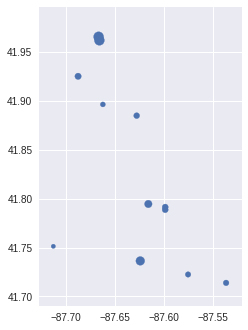

In [228]:
plt.scatter(co_conc_df['lon'], co_conc_df['lat'], s=co_conc_df['value_norm'])
plt.axes().set_aspect('equal')
plt.show()

## TODOs
* plot over a geographic map
* use heatmaps
* explore other measurements
* explore timeseries analysis